# visualization of training and testinng

## visualization of training process

In [4]:
import argparse
import pickle

checkpoint_dir = './checkpoints_mask'
#load argparse from pkl
with open(checkpoint_dir + '/args.pkl', 'rb') as f:
    args = pickle.load(f)

for arg in vars(args):
    print(f"{arg:<30}: {getattr(args, arg)}")



city                          : boston
simulation_num                : 500000
test_simulation_num           : 2000
use_given_data                : True
condition_num                 : 5
capacity_scale                : 10
weight_quantization_scale     : None
max_connection                : 4
train_data_dir                : ./data
test_data_dir                 : ./data_test
batch_size                    : 256
block_size                    : 50
observe_ratio                 : 0.5
special_mask_value            : 0.0001
n_embd                        : 64
n_head                        : 16
n_layer                       : 8
dropout                       : 0.0
use_adj_table                 : True
max_epochs                    : 10
learning_rate                 : 0.01
lr_drop_rate                  : 0.5
eval_freq                     : 10
save_freq                     : 5
device                        : cuda:1
seed                          : 0
load_dir                      : ./checkpoints_mask/


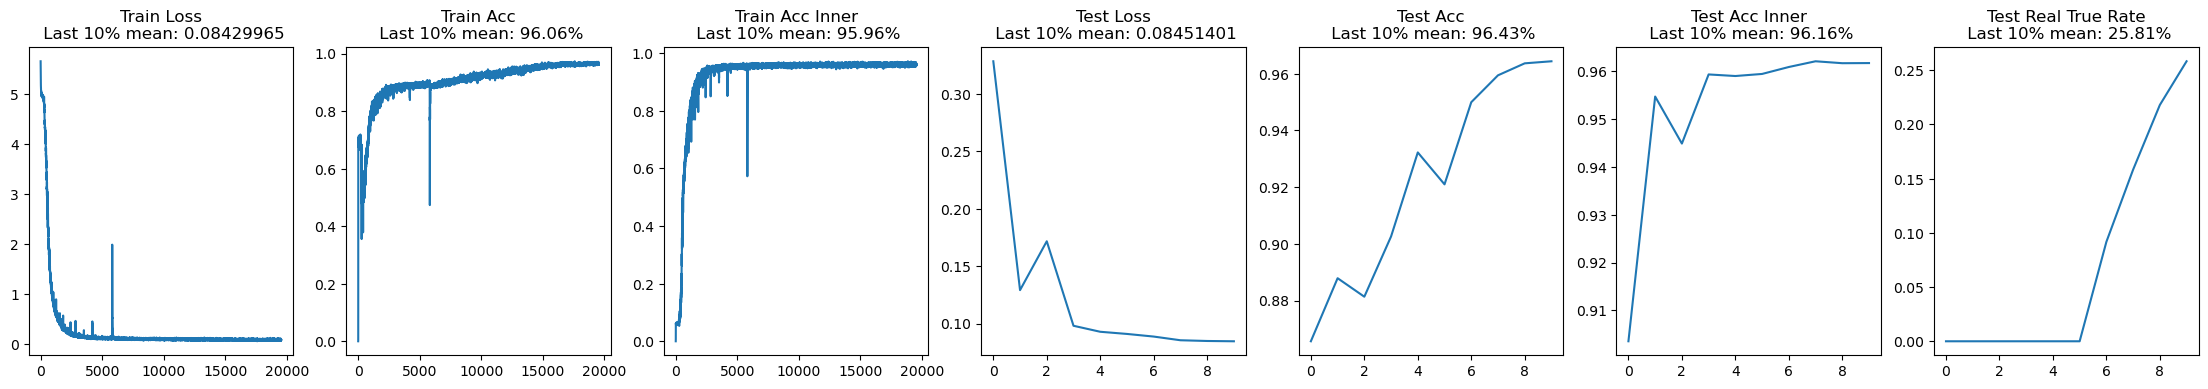

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

log_dir = './checkpoints_mask'

# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_train_acc.pkl', 'rb') as f:
    logger_train_acc = pickle.load(f)
with open(log_dir + '/logger_train_acc_inner.pkl', 'rb') as f:
    logger_train_acc_inner = pickle.load(f)
with open(log_dir + '/logger_test_loss.pkl', 'rb') as f:
    logger_test_loss = pickle.load(f)
with open(log_dir + '/logger_test_acc.pkl', 'rb') as f:
    logger_test_acc = pickle.load(f)
with open(log_dir + '/logger_test_acc_inner.pkl', 'rb') as f:
    logger_test_acc_inner = pickle.load(f)
with open(log_dir + '/logger_test_real_true_rate.pkl', 'rb') as f:
    logger_test_real_true_rate = pickle.load(f)


# plot the logger curves

visualization_num = int(len(logger_test_loss)*0.1)

plt.figure(figsize=(28, 4))

plt.subplot(1,7,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,7,2)
plt.plot(logger_train_acc)
train_acc_last = np.mean(logger_train_acc[-visualization_num:])
plt.title('Train Acc\n Last 10% mean: {:.2%}'.format(train_acc_last))

plt.subplot(1,7,3)
plt.plot(logger_train_acc_inner)
train_acc_inner_last = np.mean(logger_train_acc_inner[-visualization_num:])
plt.title('Train Acc Inner\n Last 10% mean: {:.2%}'.format(train_acc_inner_last))

plt.subplot(1,7,4)
plt.plot(logger_test_loss)
test_loss_last = np.mean(logger_test_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))

plt.subplot(1,7,5)
plt.plot(logger_test_acc)
test_acc_last = np.mean(logger_test_acc[-visualization_num:])
plt.title('Test Acc\n Last 10% mean: {:.2%}'.format(test_acc_last))

plt.subplot(1,7,6)
plt.plot(logger_test_acc_inner)
test_acc_inner_last = np.mean(logger_test_acc_inner[-visualization_num:])
plt.title('Test Acc Inner\n Last 10% mean: {:.2%}'.format(test_acc_inner_last))

plt.subplot(1,7,7)
plt.plot(logger_test_real_true_rate)
test_real_true_rate_last = np.mean(logger_test_real_true_rate[-visualization_num:])
plt.title('Test Real True Rate\n Last 10% mean: {:.2%}'.format(test_real_true_rate_last))


plt.show()

## visualization of testing new fastest trajectories

### load model

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import networkx as nx

from utils import transfer_graph, transfer_table_to_matrix
from model_mae import no_diffusion_model_cross_attention_parallel as model_class
from data_loader import traj_dataloader 

device = 'cuda:1'

# load model
load_id = None
if load_id == None:
    load_id = max([int(x.split('_')[-1].split('.')[0]) for x in os.listdir(checkpoint_dir) if 'complete_model' in x])
print('load_id:', load_id)
checkpoint_dir = './checkpoints_mask'
vocab_size = 242
n_embd, n_embd, n_layer, n_head, block_size, dropout, use_adj_table = args.n_embd, args.n_embd, args.n_layer, args.n_head, args.block_size, args.dropout, args.use_adj_table
model= model_class(vocab_size, n_embd, n_embd, n_layer, n_head, block_size, dropout, weight_quantization_scale = None, use_adj_table=use_adj_table, use_ne=True, use_ge=True, use_agent_mask=False, norm_position='prenorm', device=device)
model.load_state_dict(torch.load(checkpoint_dir + '/complete_model_{}.pth'.format(load_id)).state_dict())
model.to(device)
model = model.eval()

load_id: 10


### compare time

In [17]:
from data_loader import traj_dataloader
# load data
test_num = 2500
total_trajectories = 1
dataloader = traj_dataloader(args.city, args.train_data_dir, args.test_data_dir, 500, 500, args.condition_num, args.block_size, args.capacity_scale, args.weight_quantization_scale, args.max_connection, 10, shuffle=True, num_workers=8)
dataloader.randomize_condition(args.observe_ratio)

test_trajectory = []
test_condition = []
test_adj_table = []
test_logits = []

for(j, (condition, special_mask, adj_table)) in enumerate(dataloader.test_loader):
        # return trajectory: [B x N x T], special_mask: [B x N x T], adj_table: [B x N x V x 4 x 2]

        # random choice a traj as input, the rest as condition
        shuffled_indices = torch.randperm(condition.size(1))
        condition = condition[:,shuffled_indices,:]
        special_mask = special_mask[:,shuffled_indices,:]
        adj_table = adj_table[:,shuffled_indices,:,:,:]

        # get y, filter trajecotry into condition and get x
        condition = condition.to(device)
        y = condition[:,0,:] # [B x T]
        y = y.long()
        # todo try another filter method
        condition_ = dataloader.filter_condition(condition) # remove unboservable nodes
        x = condition_[:,0,:] # [B x T]
        condition = condition_[:,1:,:] # [B x N-1 x T]

        if use_adj_table:
            adj_table = adj_table[:,0,:,:,:].to(device) # [B x V x 4 x 2]
        else:
            raise ValueError('No adj matrix in current version, please use adj table')
        
        special_mask = special_mask[:,0,:].to(device)
        special_mask_ = (special_mask).clamp(0,1).float()


        logits,_ = model(x, condition, adj_table, None, None, special_mask_)
        test_trajectory.append(y.cpu().numpy().astype(np.int32))
        test_condition.append(x.cpu().numpy().astype(np.int32))
        test_adj_table.append(adj_table.cpu().numpy())
        test_logits.append(logits.detach().cpu().numpy())

test_trajectory = np.concatenate(test_trajectory, axis=0)
test_condition = np.concatenate(test_condition, axis=0)
test_adj_table = np.concatenate(test_adj_table, axis=0)
test_logits = np.concatenate(test_logits, axis=0)

predic_trajectory = np.argmax(test_logits, axis=-1)

(50, 242)
trajectory num: 50
difference per time: [   0.   21.    7.   -1.  -13.   40.   37.  -14.   66.  -25.    5.    3.
   10.  -52.  -15.   22.  -32.   21.   -8.  -49.   51.   49.   13.   -6.
   24.   -4.   52.   -1.   -7.   16.   12.   84.   -5.   37.    7.   44.
  -39. -233.   -1.    3.    2.   40.   -1.   39.    8.  101.  -25.    7.
    2.   33.    7.   -8.   -2.   62.   38.   -5.   33.   -4.  -10.   -1.
  -16.  -11.  -33.   49.   -5.   -5.    1.    0.   -3.    0.    1.    0.
   -3.    2.    0.    0.  -14.  -11.   10.   13.   39.  -87.  -10.  -13.
  115.   77.  -12.   15.   94.    4.   40.   -1.   -4.    3.    9.  -25.
  -68.   -5.   25.  -67.   -6.   48.   56.   37.  -12.   35.    3.   13.
   35.   -2.  -87.  -19.  -60.  -47.   29.   28.   35.    1.   15.  -11.
   41.    8.    0.  -21.   75.   -4.   14.    0.    0.   27.    7.    0.
    6.   -3.    0.    0.    0.    0.   -1.    0.   -1.    7.   24.    9.
   12.    0.    0.   -4.    8.   49.  -57.  -85.  -32.  -13. -105.  -34.
 

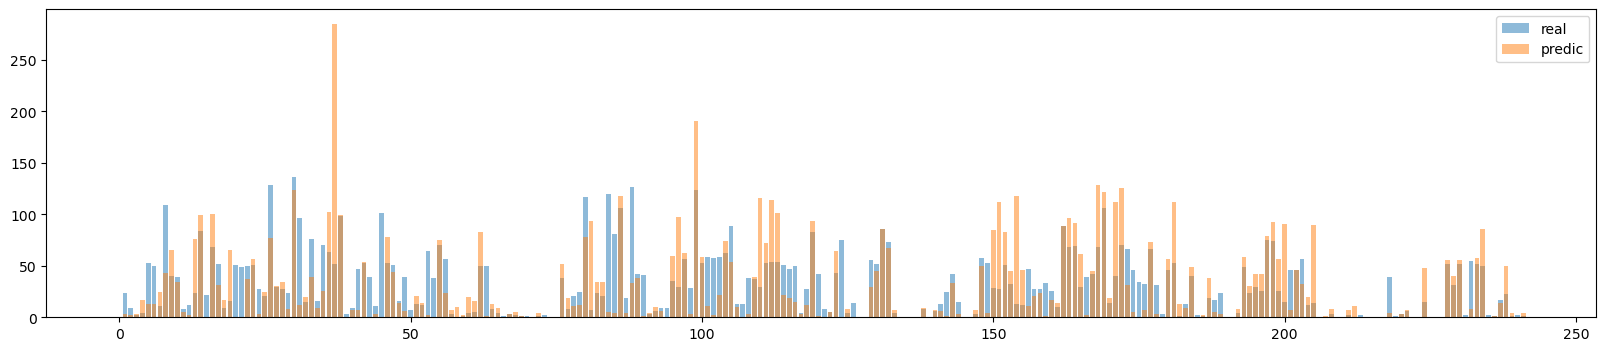

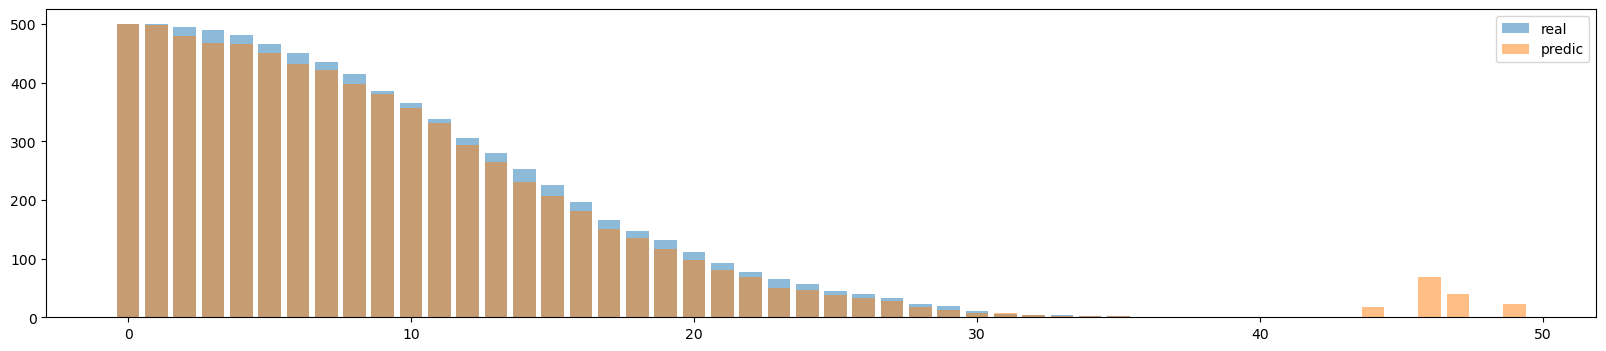

In [21]:
from utils import calculate_load

real_load = calculate_load(test_trajectory, vocab_size)
predic_load = calculate_load(predic_trajectory, vocab_size)
exp_load = np.mean(test_logits, axis=0)
print(exp_load.shape)

real_load_per_time = np.sum(real_load, axis=0)
predic_load_per_time = np.sum(predic_load, axis=0)
real_load_per_road = np.sum(real_load, axis=1)
predic_load_per_road = np.sum(predic_load, axis=1)

real_load_total = np.sum(real_load)
predic_load_total = np.sum(predic_load)

print('trajectory num:', len(real_load))
print('difference per time:', real_load_per_time - predic_load_per_time)
print('difference per road:', real_load_per_road - predic_load_per_road)
print('difference total:', real_load_total - predic_load_total)
print('abs difference rate:', np.abs(real_load_total - predic_load_total) / len(real_load))
print('abs exp difference rate:', np.abs(np.sum(exp_load) - predic_load_total) / len(real_load))

plt.figure(figsize=(20, 4))
plt.bar(range(len(real_load_per_time)), real_load_per_time, alpha=0.5, label='real')
plt.bar(range(len(predic_load_per_time)), predic_load_per_time, alpha=0.5, label='predic')
plt.legend()
plt.show()

plt.figure(figsize=(20, 4))
plt.bar(range(len(real_load_per_road)), real_load_per_road, alpha=0.5, label='real')
plt.bar(range(len(predic_load_per_road)), predic_load_per_road, alpha=0.5, label='predic')
plt.legend()
plt.show()


### print trajectory

In [12]:
# print the trajectory
from utils import print_trajectory

print('Without correction:')

print(test_trajectory.shape)
print_trajectory(predic_trajectory, test_trajectory, test_condition)

Without correction:
(10, 50)
weighted graph 1  ,
true: [34 16 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
pred: [164  16   0   0   0   0   0 144   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
cond: [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


weighted graph 2  ,
true: [123  87  86 201 202  97  85  84 166 119 120   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
pred: [ 30  30 120  17 228  96  81  24 205 119   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 

### plot trajectory

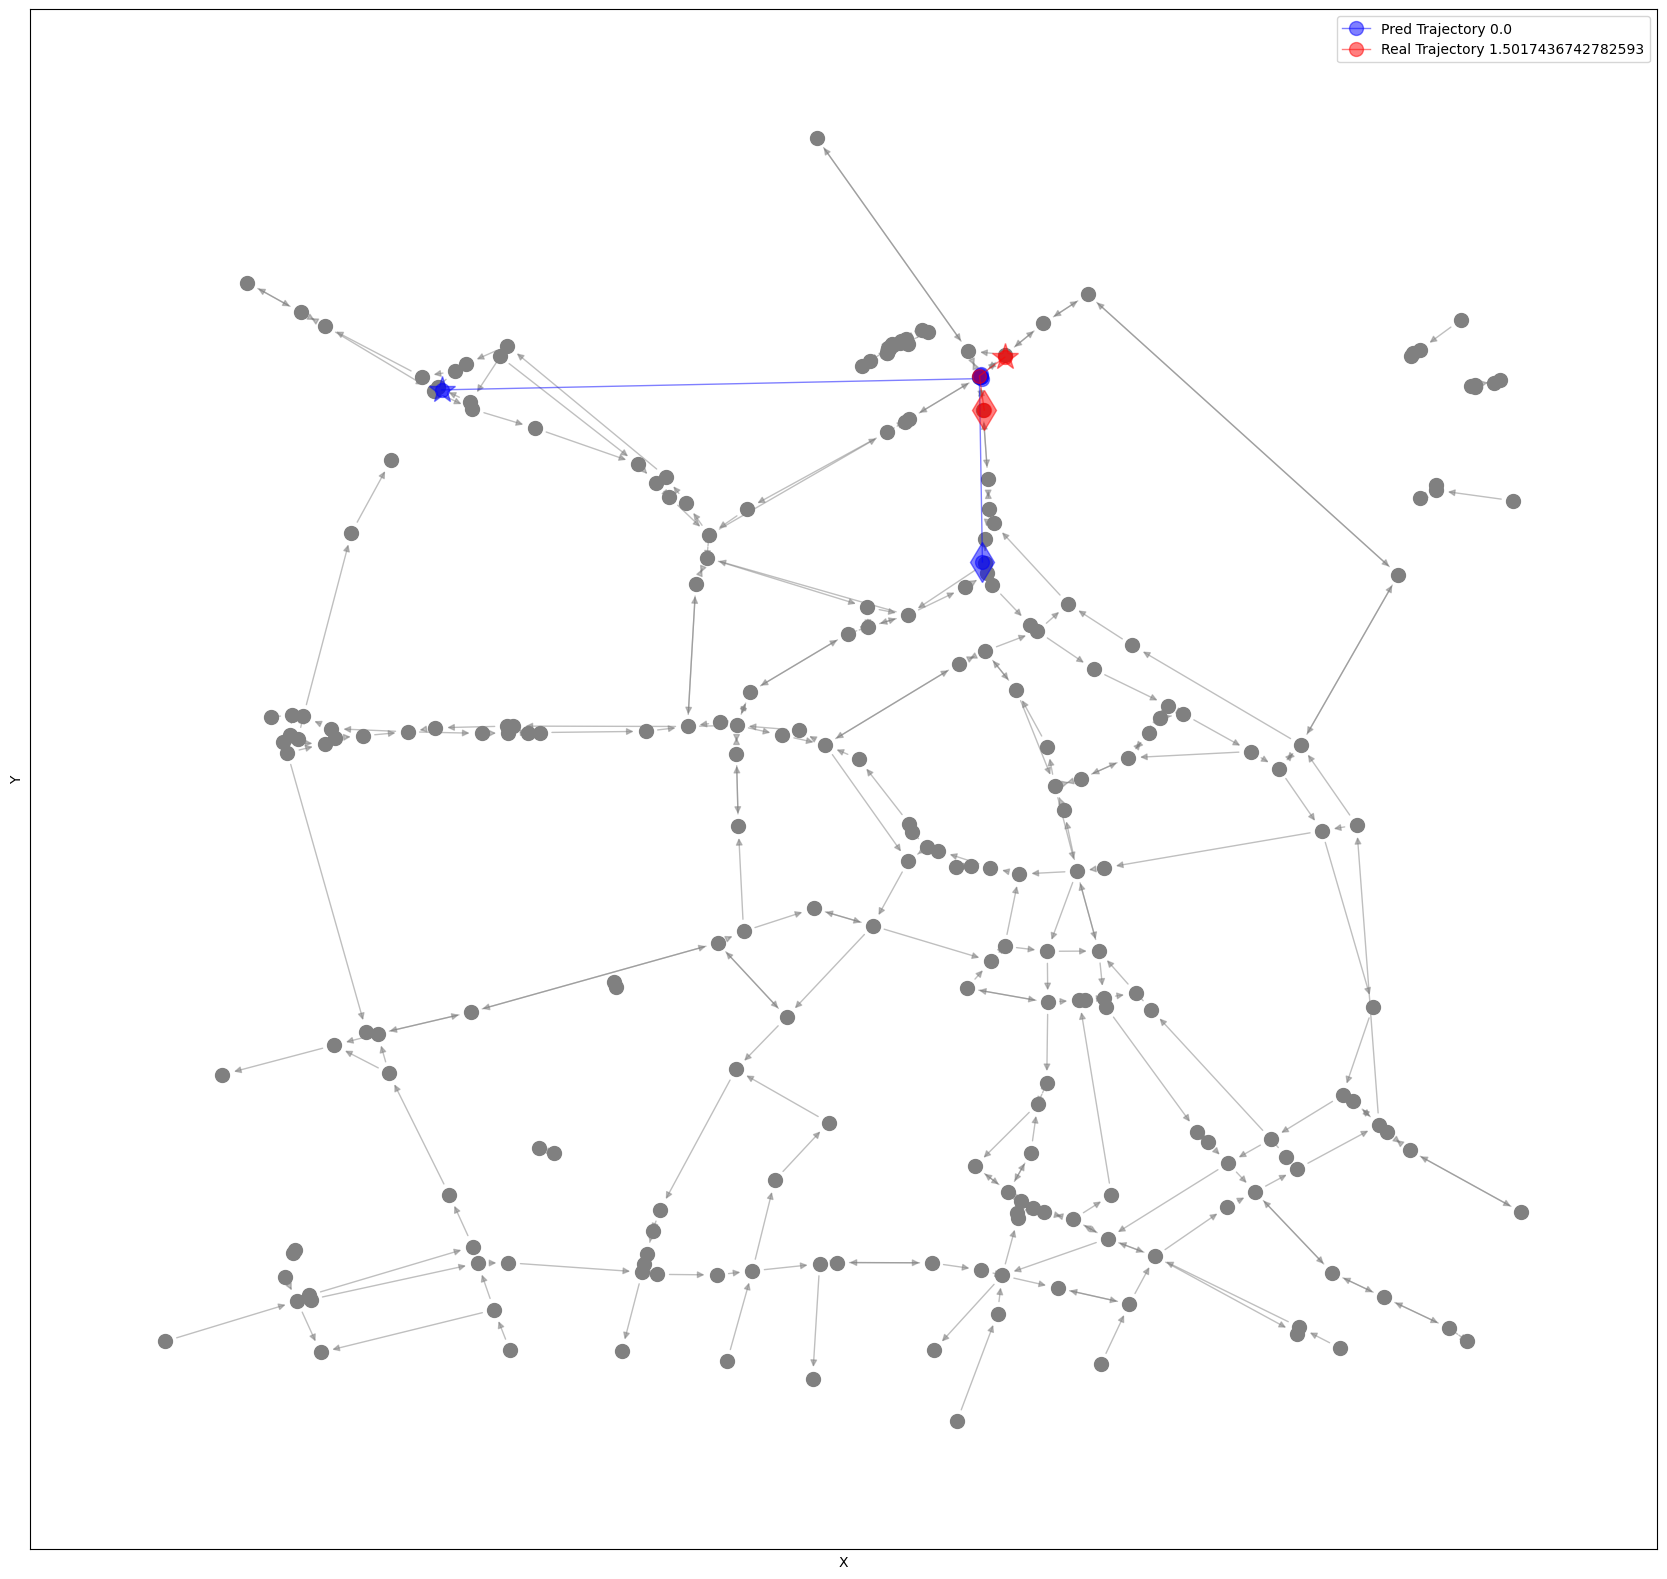

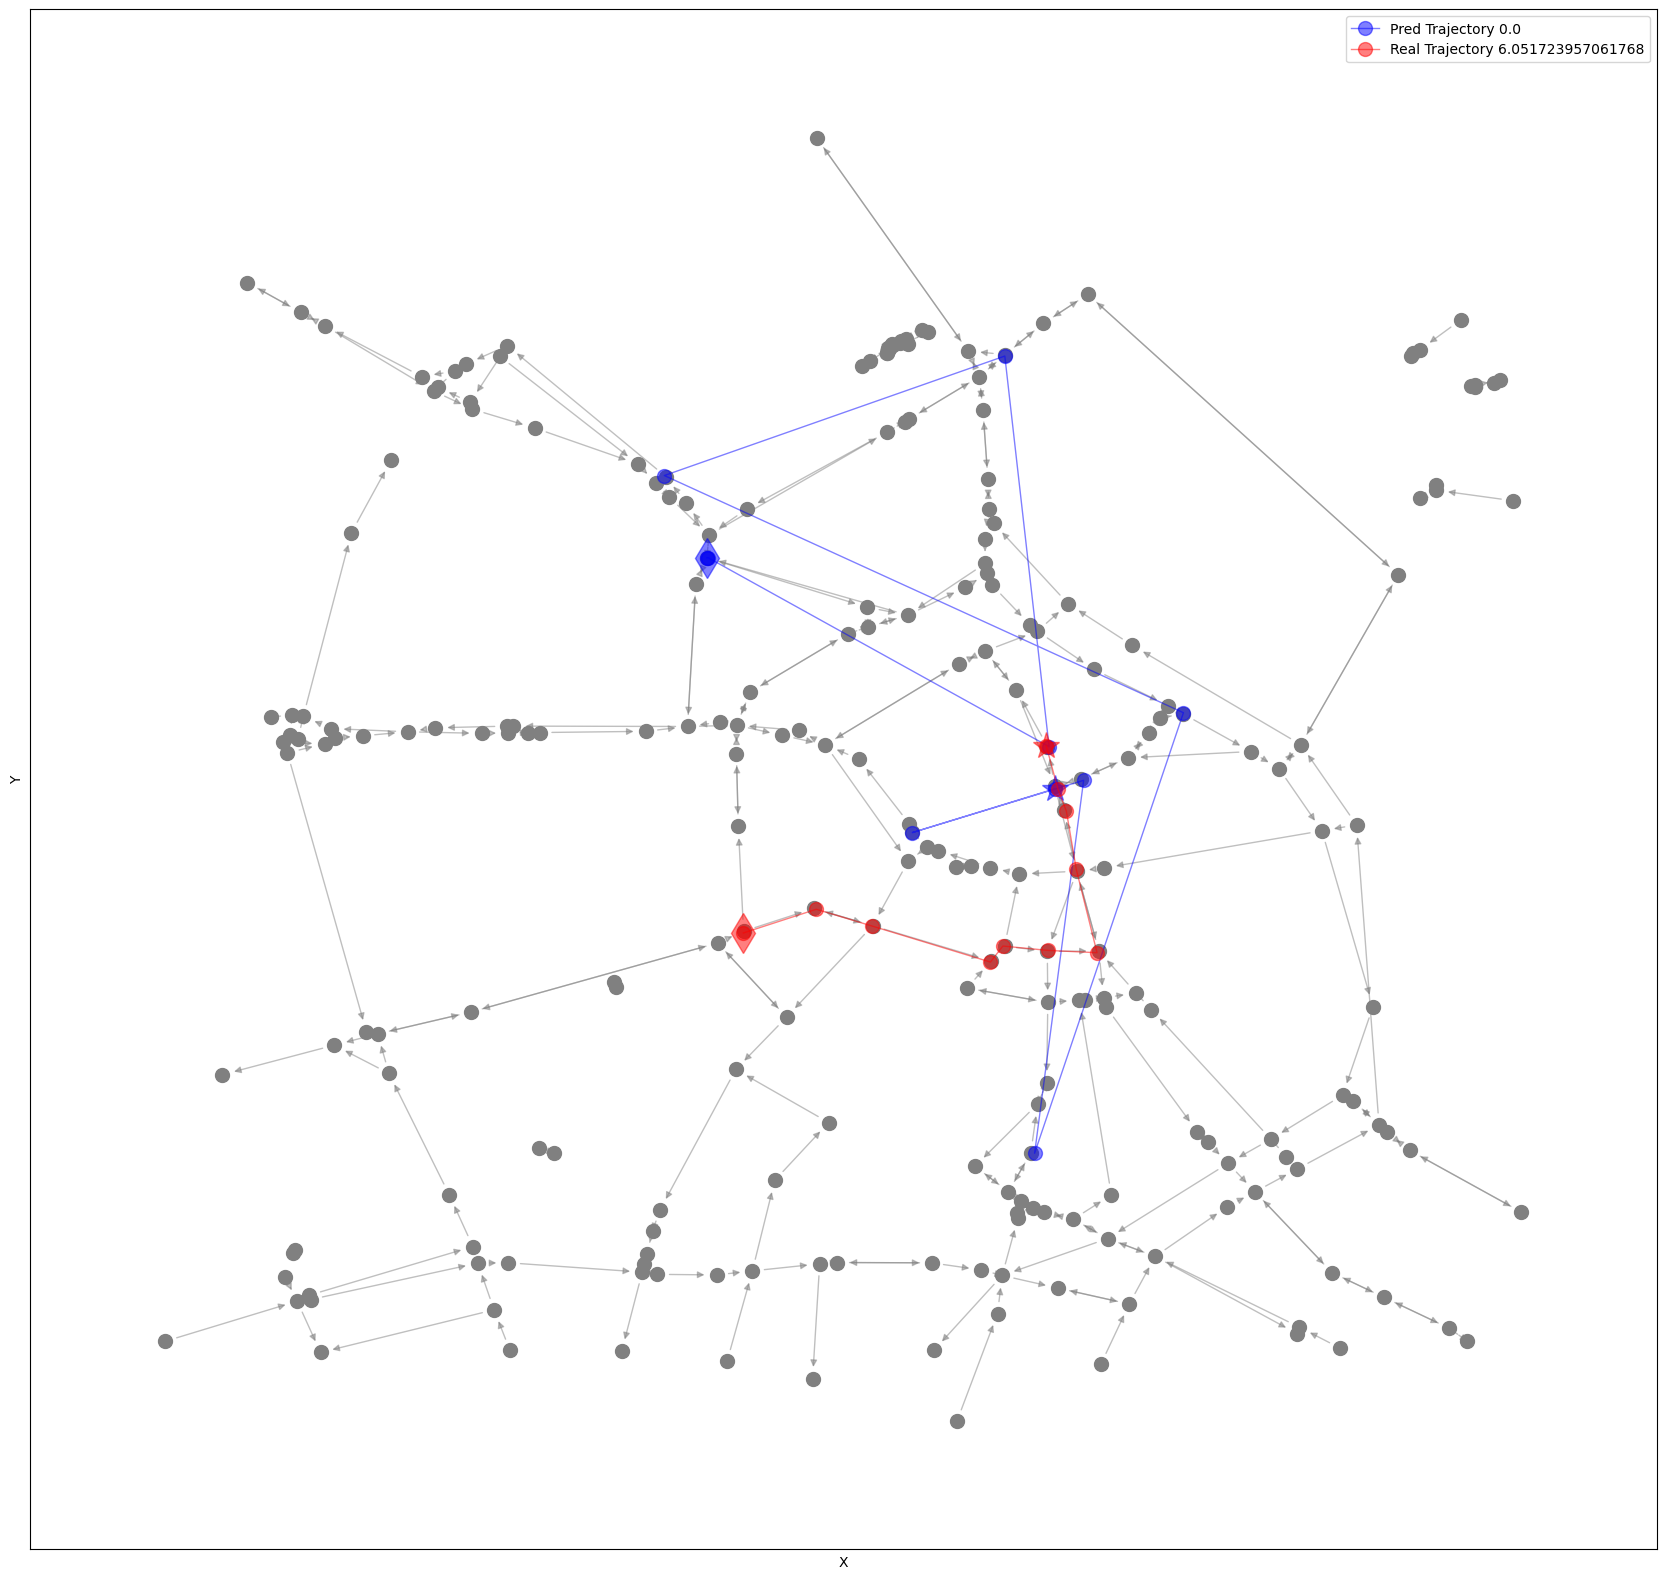

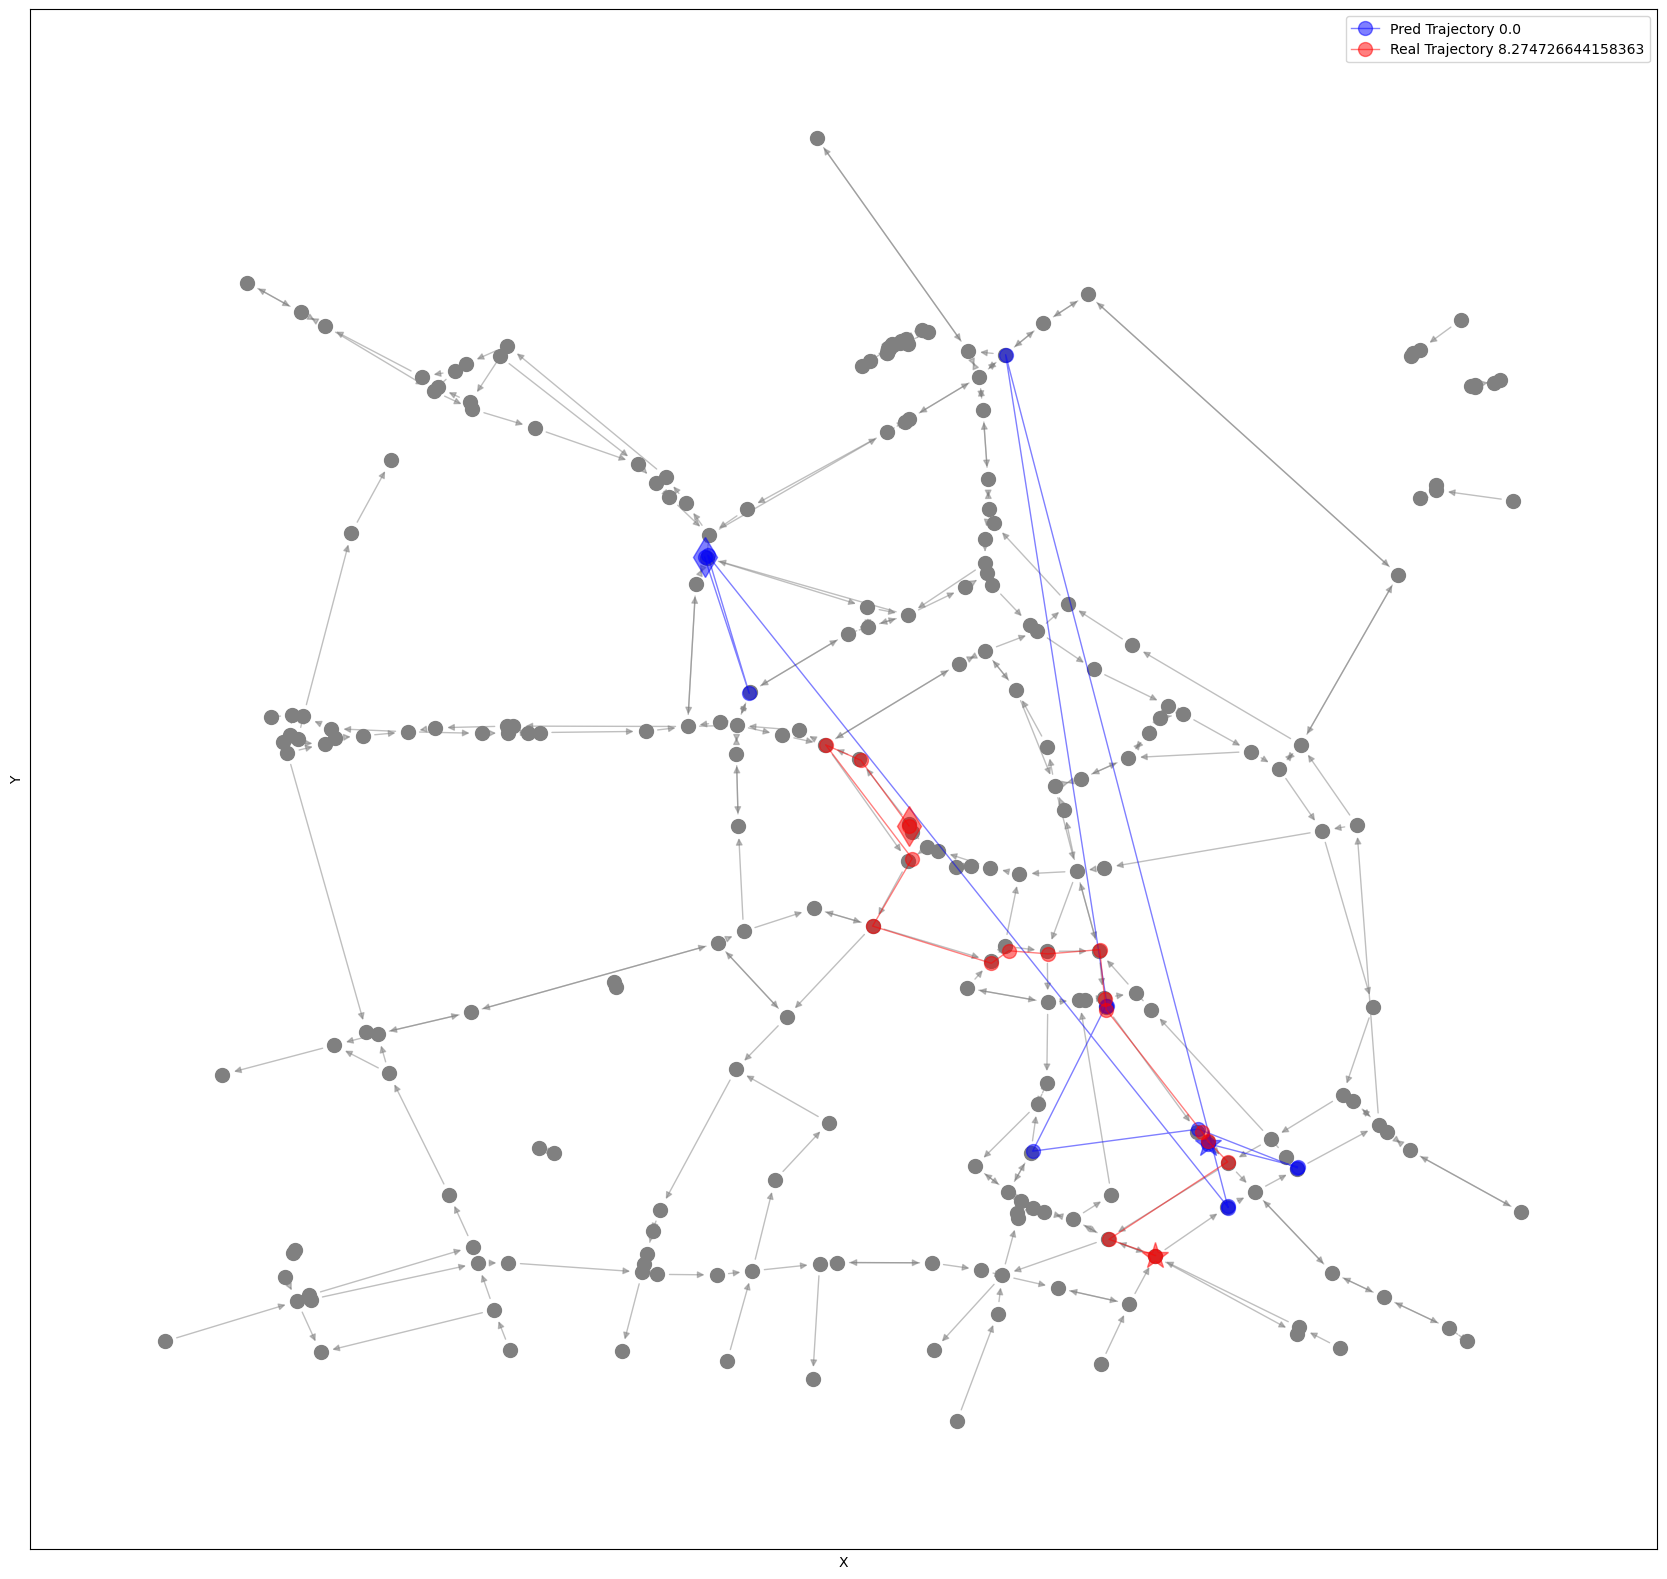

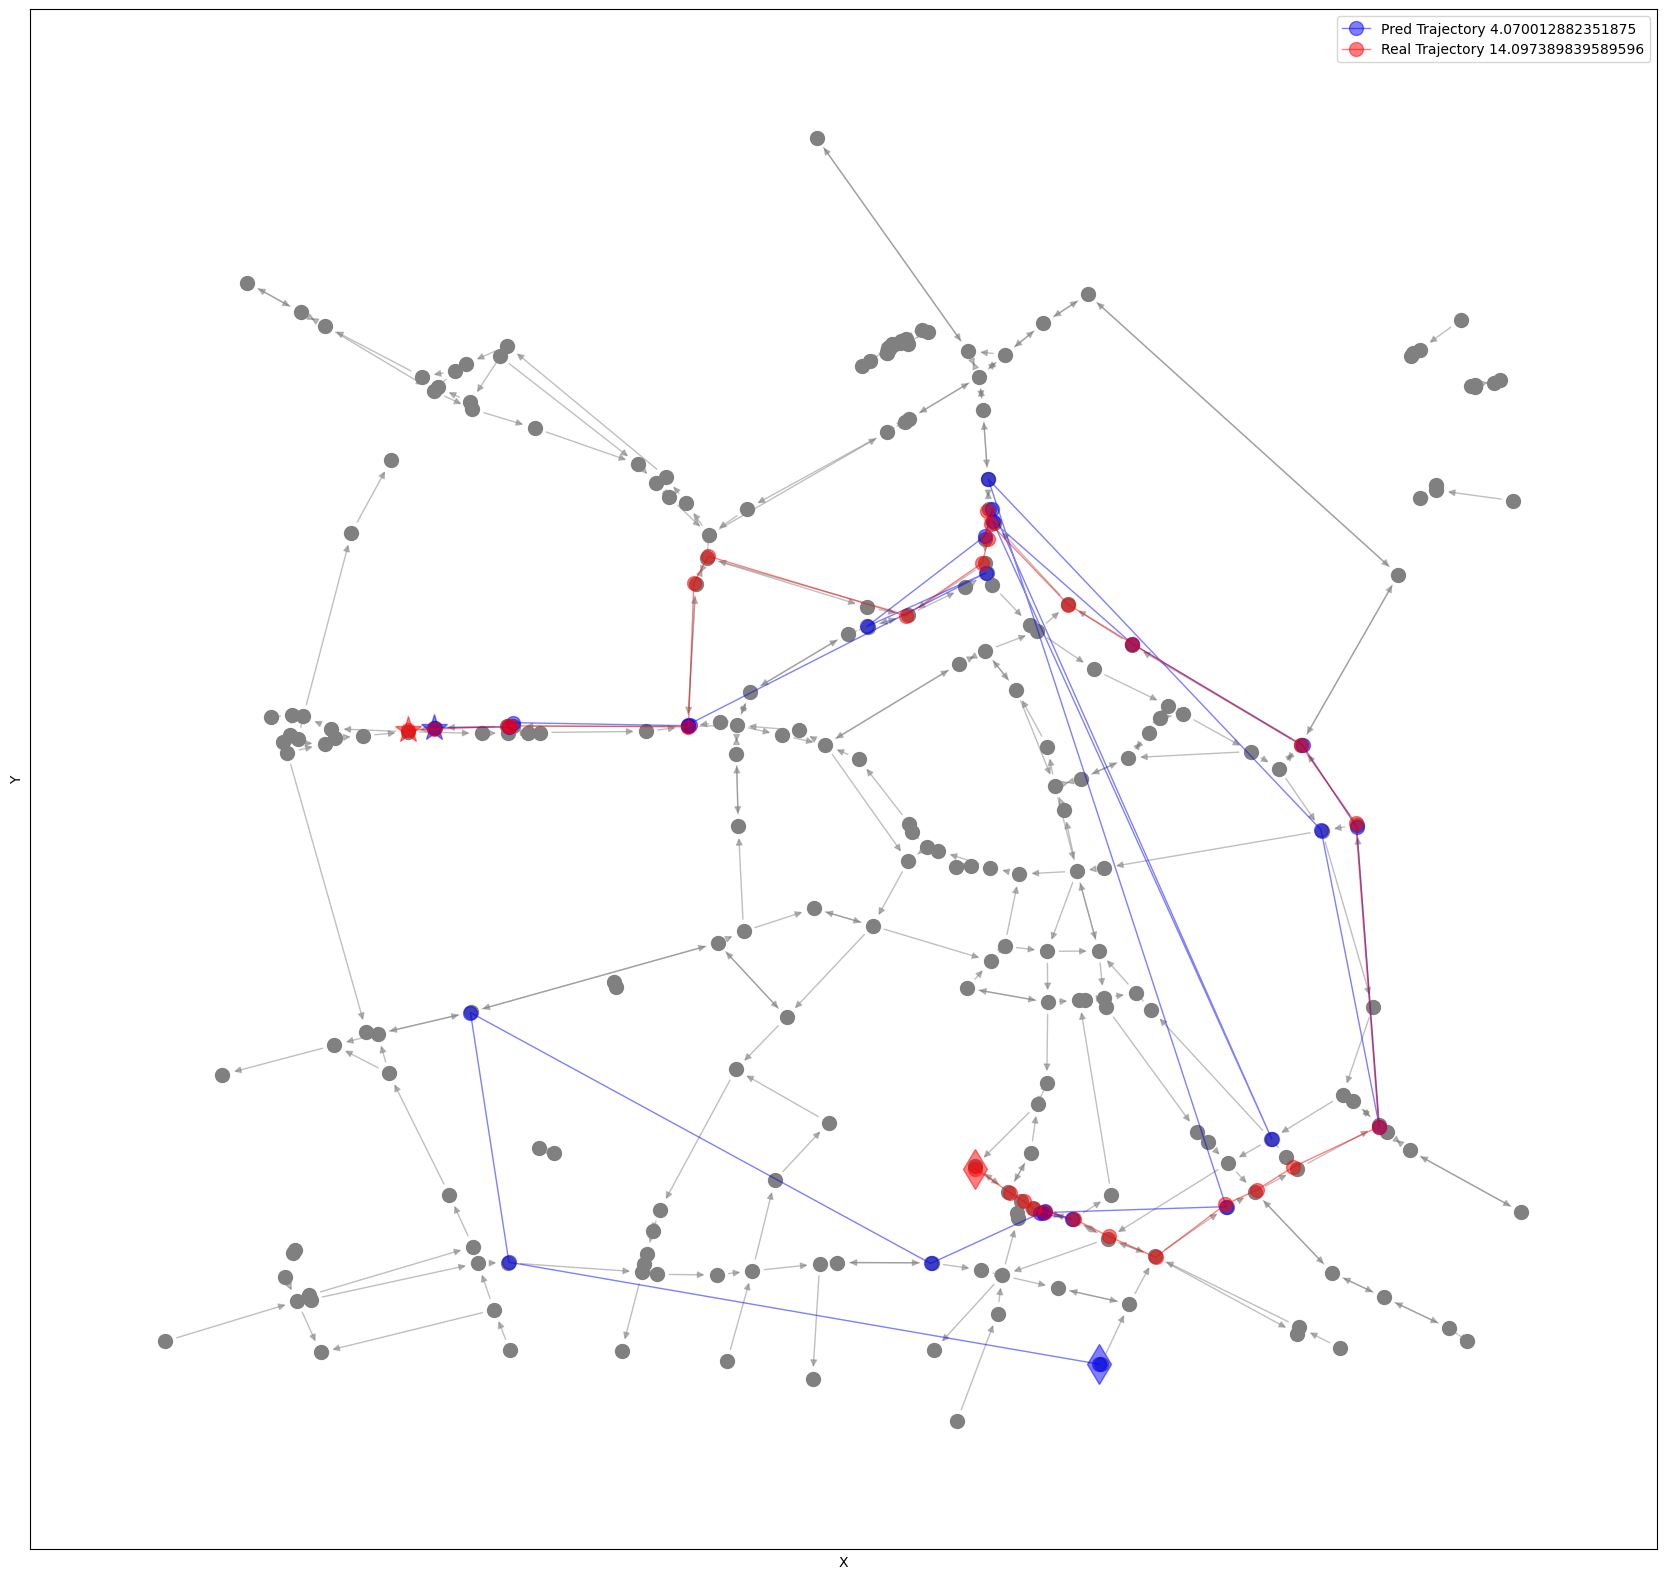

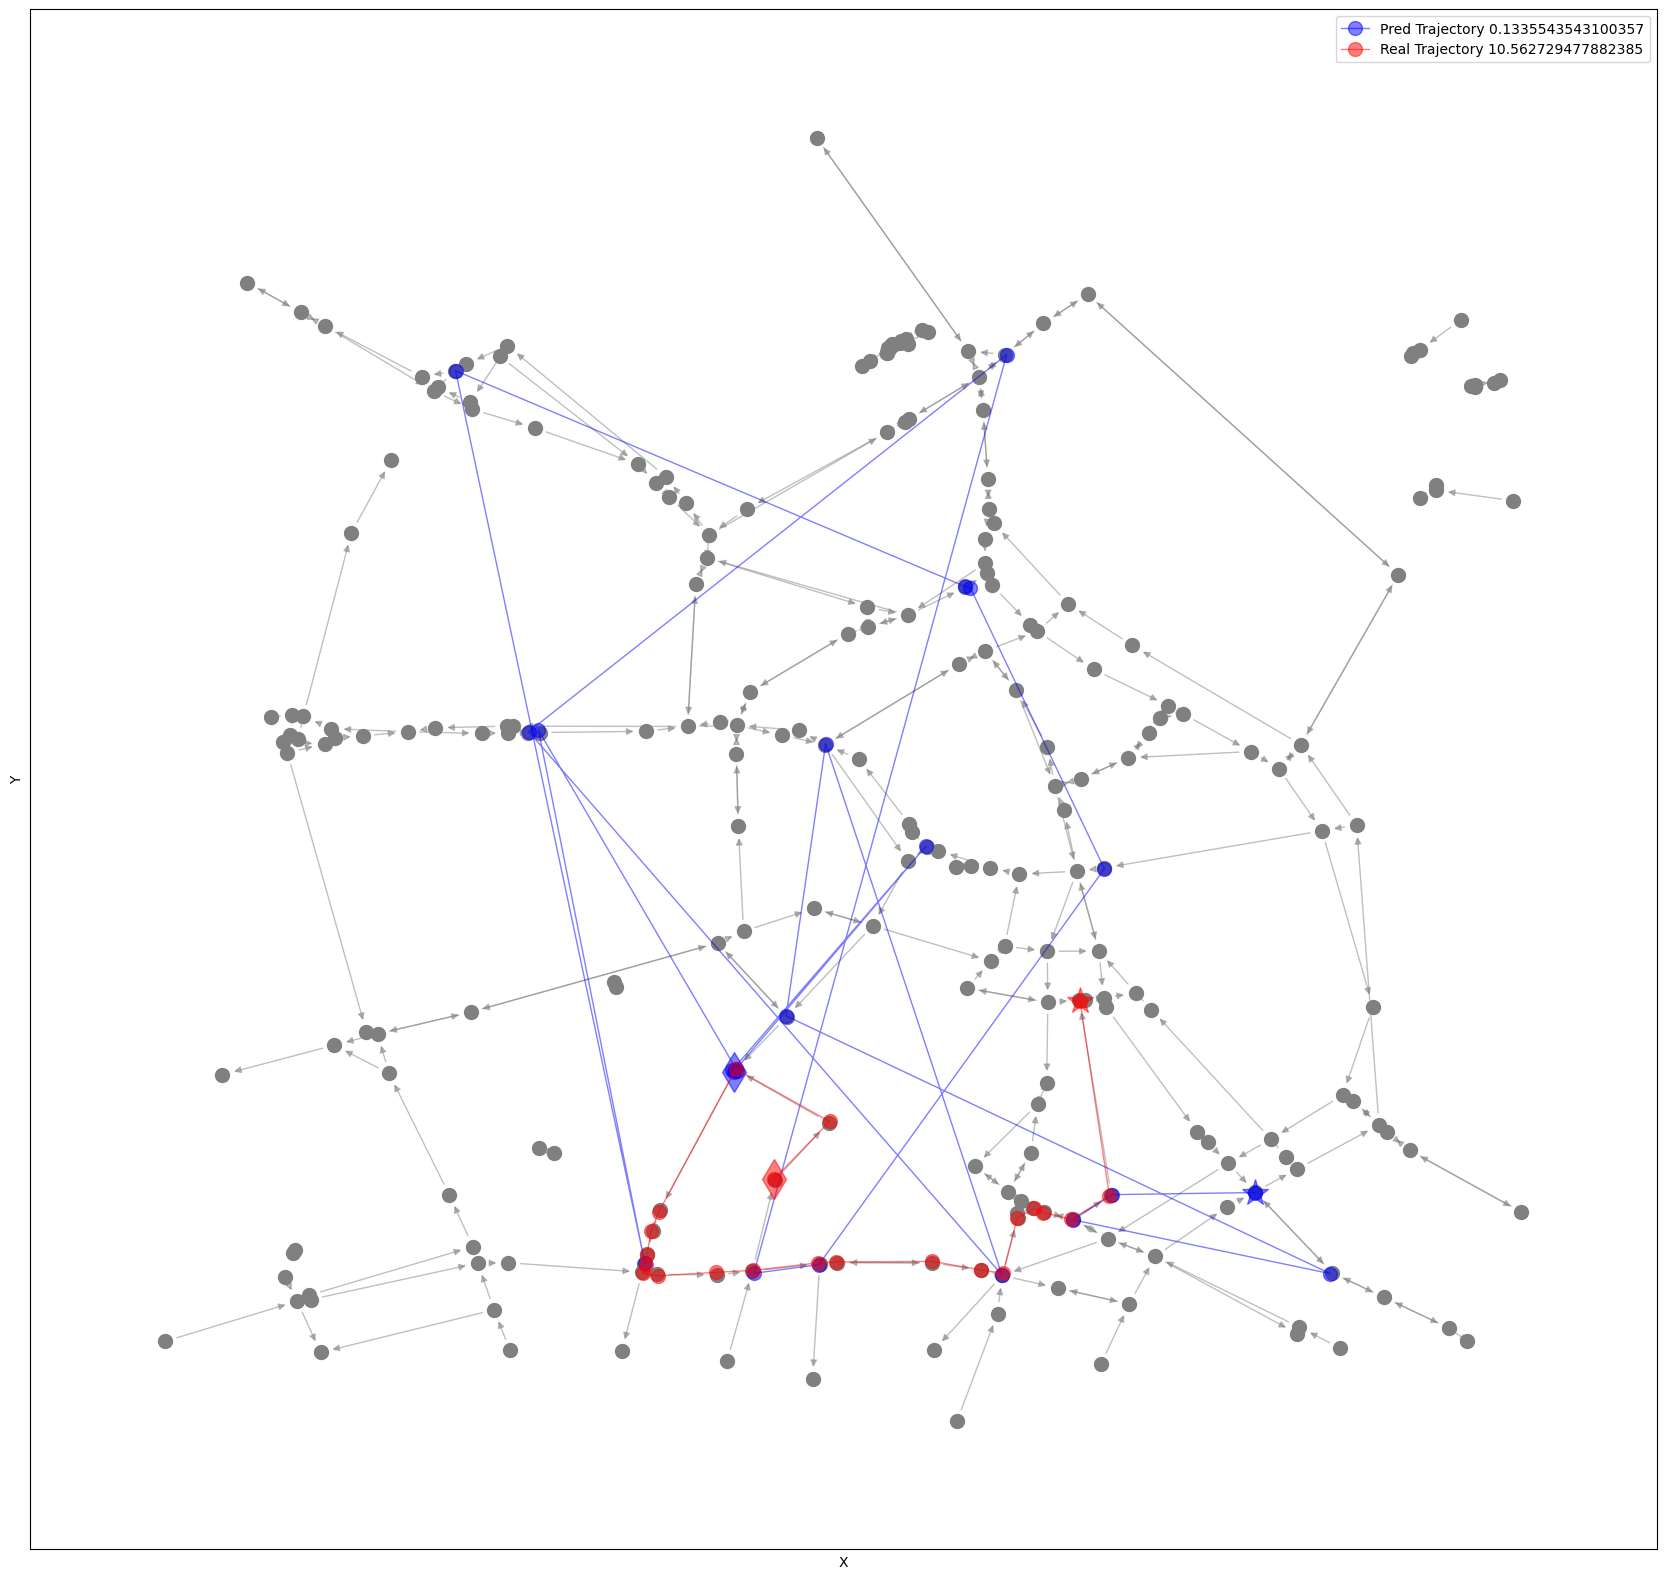

In [13]:
# plot the trajectory
from utils import plot_trajs, remove_special_token
from dataset import read_city

_, pos = read_city('boston')

fig_size = 20
plot_num = min(5, test_num)

for i in range(plot_num):
    fig, ax = plt.subplots(1, total_trajectories, figsize=((fig_size+1)*total_trajectories, fig_size))
    for j in range(total_trajectories):
        traj = predic_trajectory[i] # (block_size,)
        traj_ = test_trajectory[i] # (block_size,)
        traj = remove_special_token(traj)
        traj_ = remove_special_token(traj_) # original 1-index, now 0-index

        test_weight_adj = transfer_table_to_matrix(test_adj_table[i])
        G = transfer_graph(test_adj_table[i])
        if total_trajectories == 1:
            plot_trajs(ax, G, pos, test_weight_adj, traj, traj_, ground_truth=False)
        else:
            plot_trajs(ax[j], G, pos, test_weight_adj, traj, traj_, ground_truth=False)
    plt.show()


IndexError: list index out of range

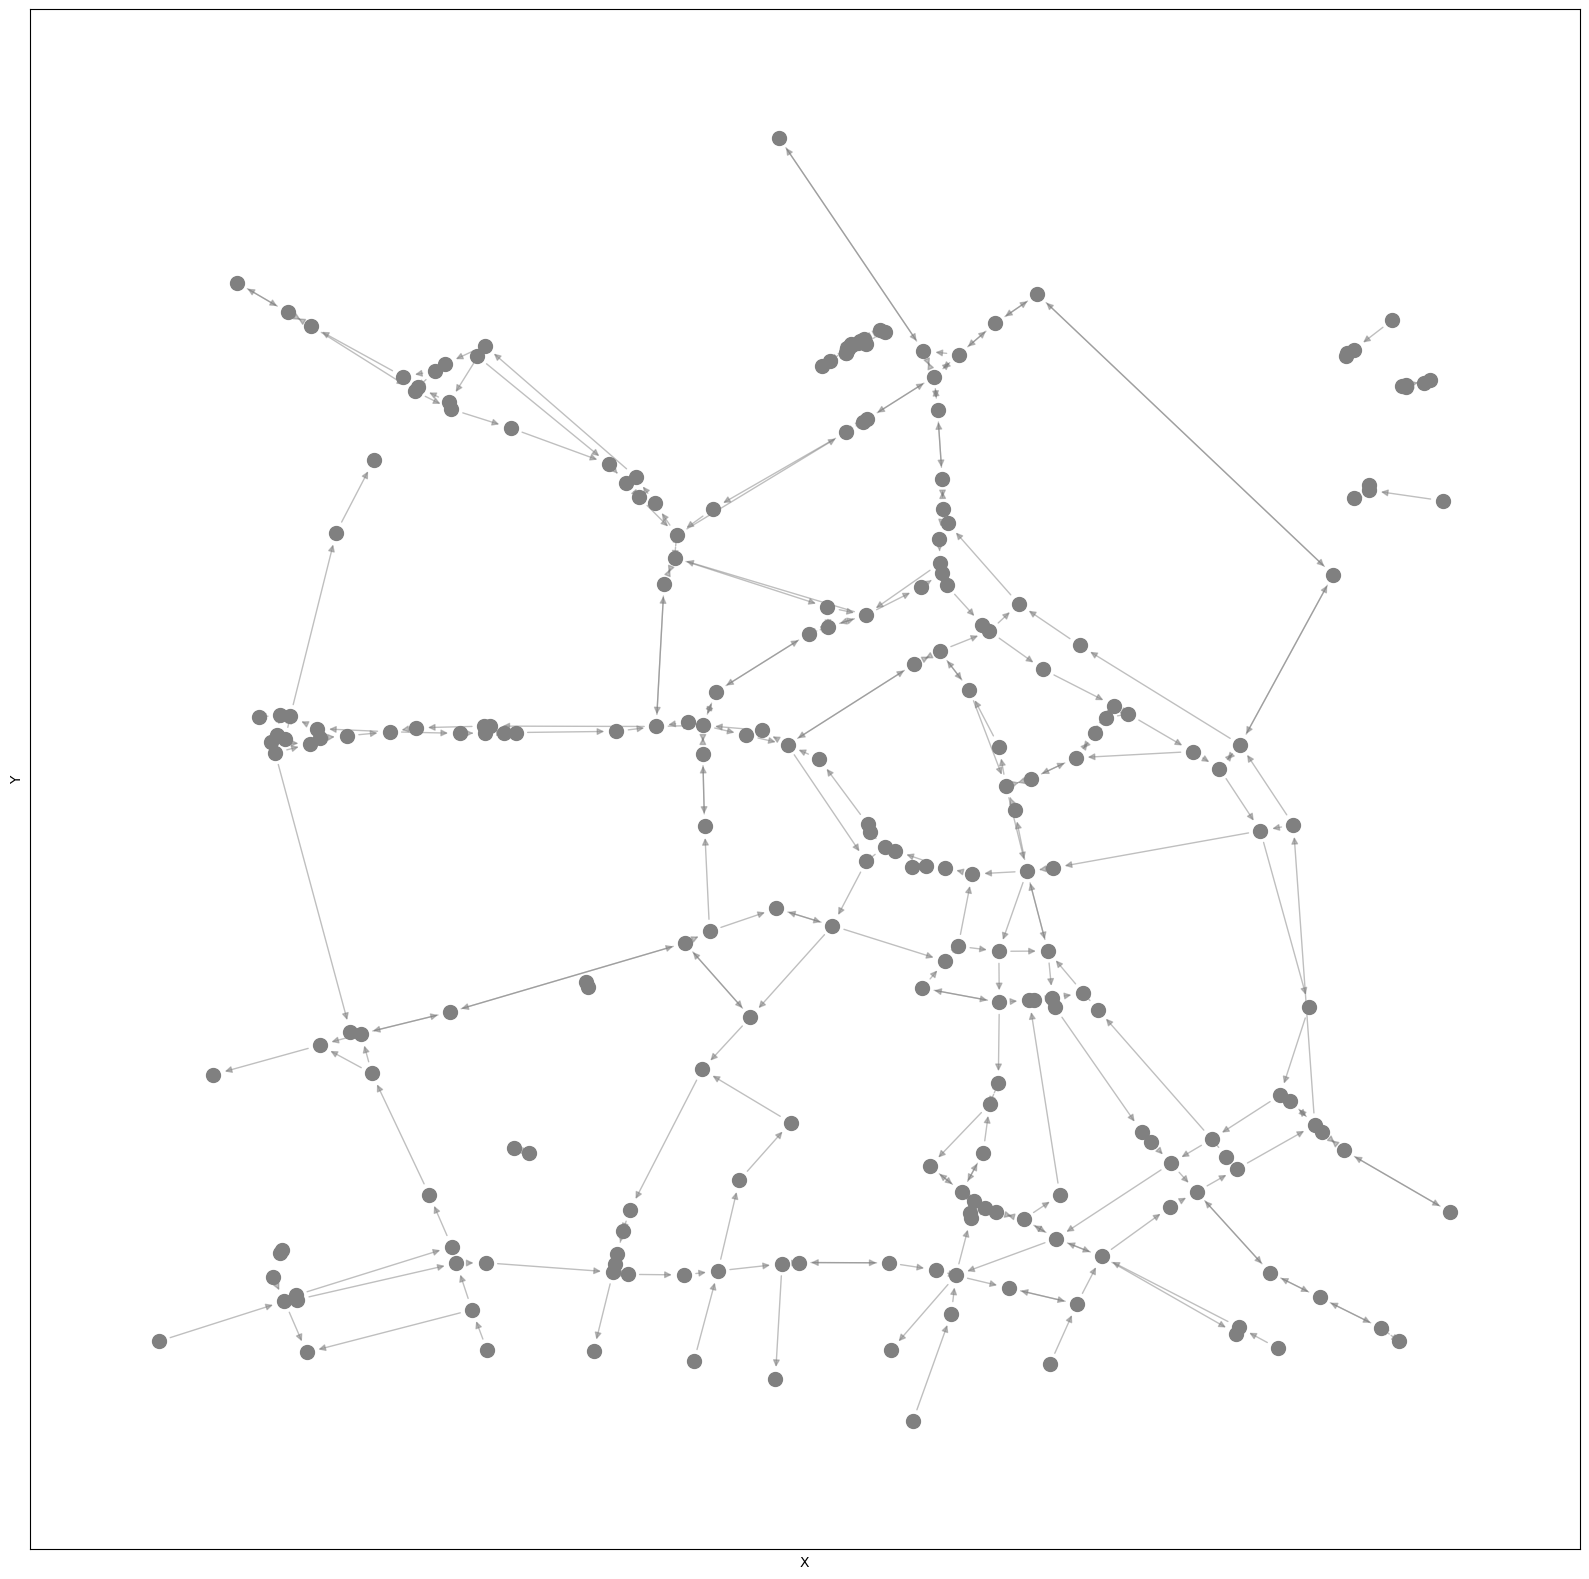

In [16]:
# plot pure graph
from utils import plot_trajs
from dataset import read_city

_, pos = read_city('boston')

fig_size = 20

fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))

test_weight_adj = transfer_table_to_matrix(test_adj_table[i])
G = transfer_graph(test_adj_table[i])
plot_trajs(ax, G, pos, test_weight_adj, [], [], ground_truth=False)
plt.show()